# LRSP CNOTs, depht and fidelity
### Section 2.1 of the Supplementary Information (Fig.3)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random

from qiskit import transpile
from qiskit.providers.aer.backends import AerSimulator

from qclib.state_preparation import LowRankInitialize
from qclib.state_preparation.lowrank import cnot_count as cnots

In [2]:
def _fidelity(input_state, transpiled_circuit):
    backend = AerSimulator()
    transpiled_circuit.save_statevector()
    ket = np.asarray(backend.run(transpiled_circuit).result().get_statevector())
    bra = np.conj(input_state)
    
    return np.abs(bra.dot(ket))**2

def _counts(input_state, r=0, result=None, plot=False, partition=None):
    circuit = LowRankInitialize(input_state, lr_params={'lr':r, 'partition':partition}).definition
    transpiled_circuit = transpile(circuit, basis_gates=['u', 'cx'], optimization_level=3)

    if plot:
        _plot_density_matrix(circuit)

    n_cx = transpiled_circuit.count_ops().get('cx', 0)
    n_dp = transpiled_circuit.depth()
    
    fidelity = _fidelity(input_state, transpiled_circuit)

    if result is not None:
        result.append([int(np.log2(r)), n_cx, n_dp, fidelity])

    est_cx = cnots(input_state, low_rank=r, method='estimate')

    print('\tCNOTs = {0}\tdepth = {1}\tfidelity={2}\test.cx={3}'.format(n_cx, n_dp, fidelity, est_cx))

def _grid_search(input_state, plot=False):
    result = []

    n = int(np.log2(len(input_state)))
    for m in list(range(n//2+1))[::-1]:
        r = 2**m
        print('rank = {0}:'.format(r), end='')
        _counts(input_state, r=r, result=result, plot=plot)

    return result

# Random dense states

In [3]:
rnd = np.random.RandomState(42)

min_n = 11
max_n = 14

result = {}
for n in range(min_n, max_n+1):
    N = 2**n
    input_state = ((1.0 - 0.001) * rnd.rand(N) + 0.001) + ((1.0 - 0.001) * rnd.rand(N) + 0.001) * 1j
    input_state = input_state/np.linalg.norm(input_state)

    print('\nn = {0}:'.format(n))
    result[n] = _grid_search(input_state)



n = 11:
rank = 32:	CNOTs = 1862	depth = 2755	fidelity=1.0000000000000053	est.cx=1863
rank = 16:	CNOTs = 1448	depth = 2193	fidelity=0.9454428262553948	est.cx=1449
rank = 8:	CNOTs = 796	depth = 1049	fidelity=0.8708688197745516	est.cx=796
rank = 4:	CNOTs = 376	depth = 497	fidelity=0.8143198335941657	est.cx=376
rank = 2:	CNOTs = 176	depth = 233	fidelity=0.7788865879321158	est.cx=176
rank = 1:	CNOTs = 68	depth = 51	fidelity=0.7594341638536505	est.cx=68

n = 12:
rank = 64:	CNOTs = 3788	depth = 3702	fidelity=0.9999999999999967	est.cx=3789
rank = 32:	CNOTs = 2811	depth = 2754	fidelity=0.9727361612666174	est.cx=2812
rank = 16:	CNOTs = 2226	depth = 2193	fidelity=0.9043909736770245	est.cx=2227
rank = 8:	CNOTs = 1063	depth = 1049	fidelity=0.8415941388498956	est.cx=1063
rank = 4:	CNOTs = 505	depth = 497	fidelity=0.7972445116376978	est.cx=505
rank = 2:	CNOTs = 239	depth = 233	fidelity=0.7714605604876444	est.cx=239
rank = 1:	CNOTs = 94	depth = 51	fidelity=0.7573203820550202	est.cx=94

n = 13:
rank =

# Plot dense results

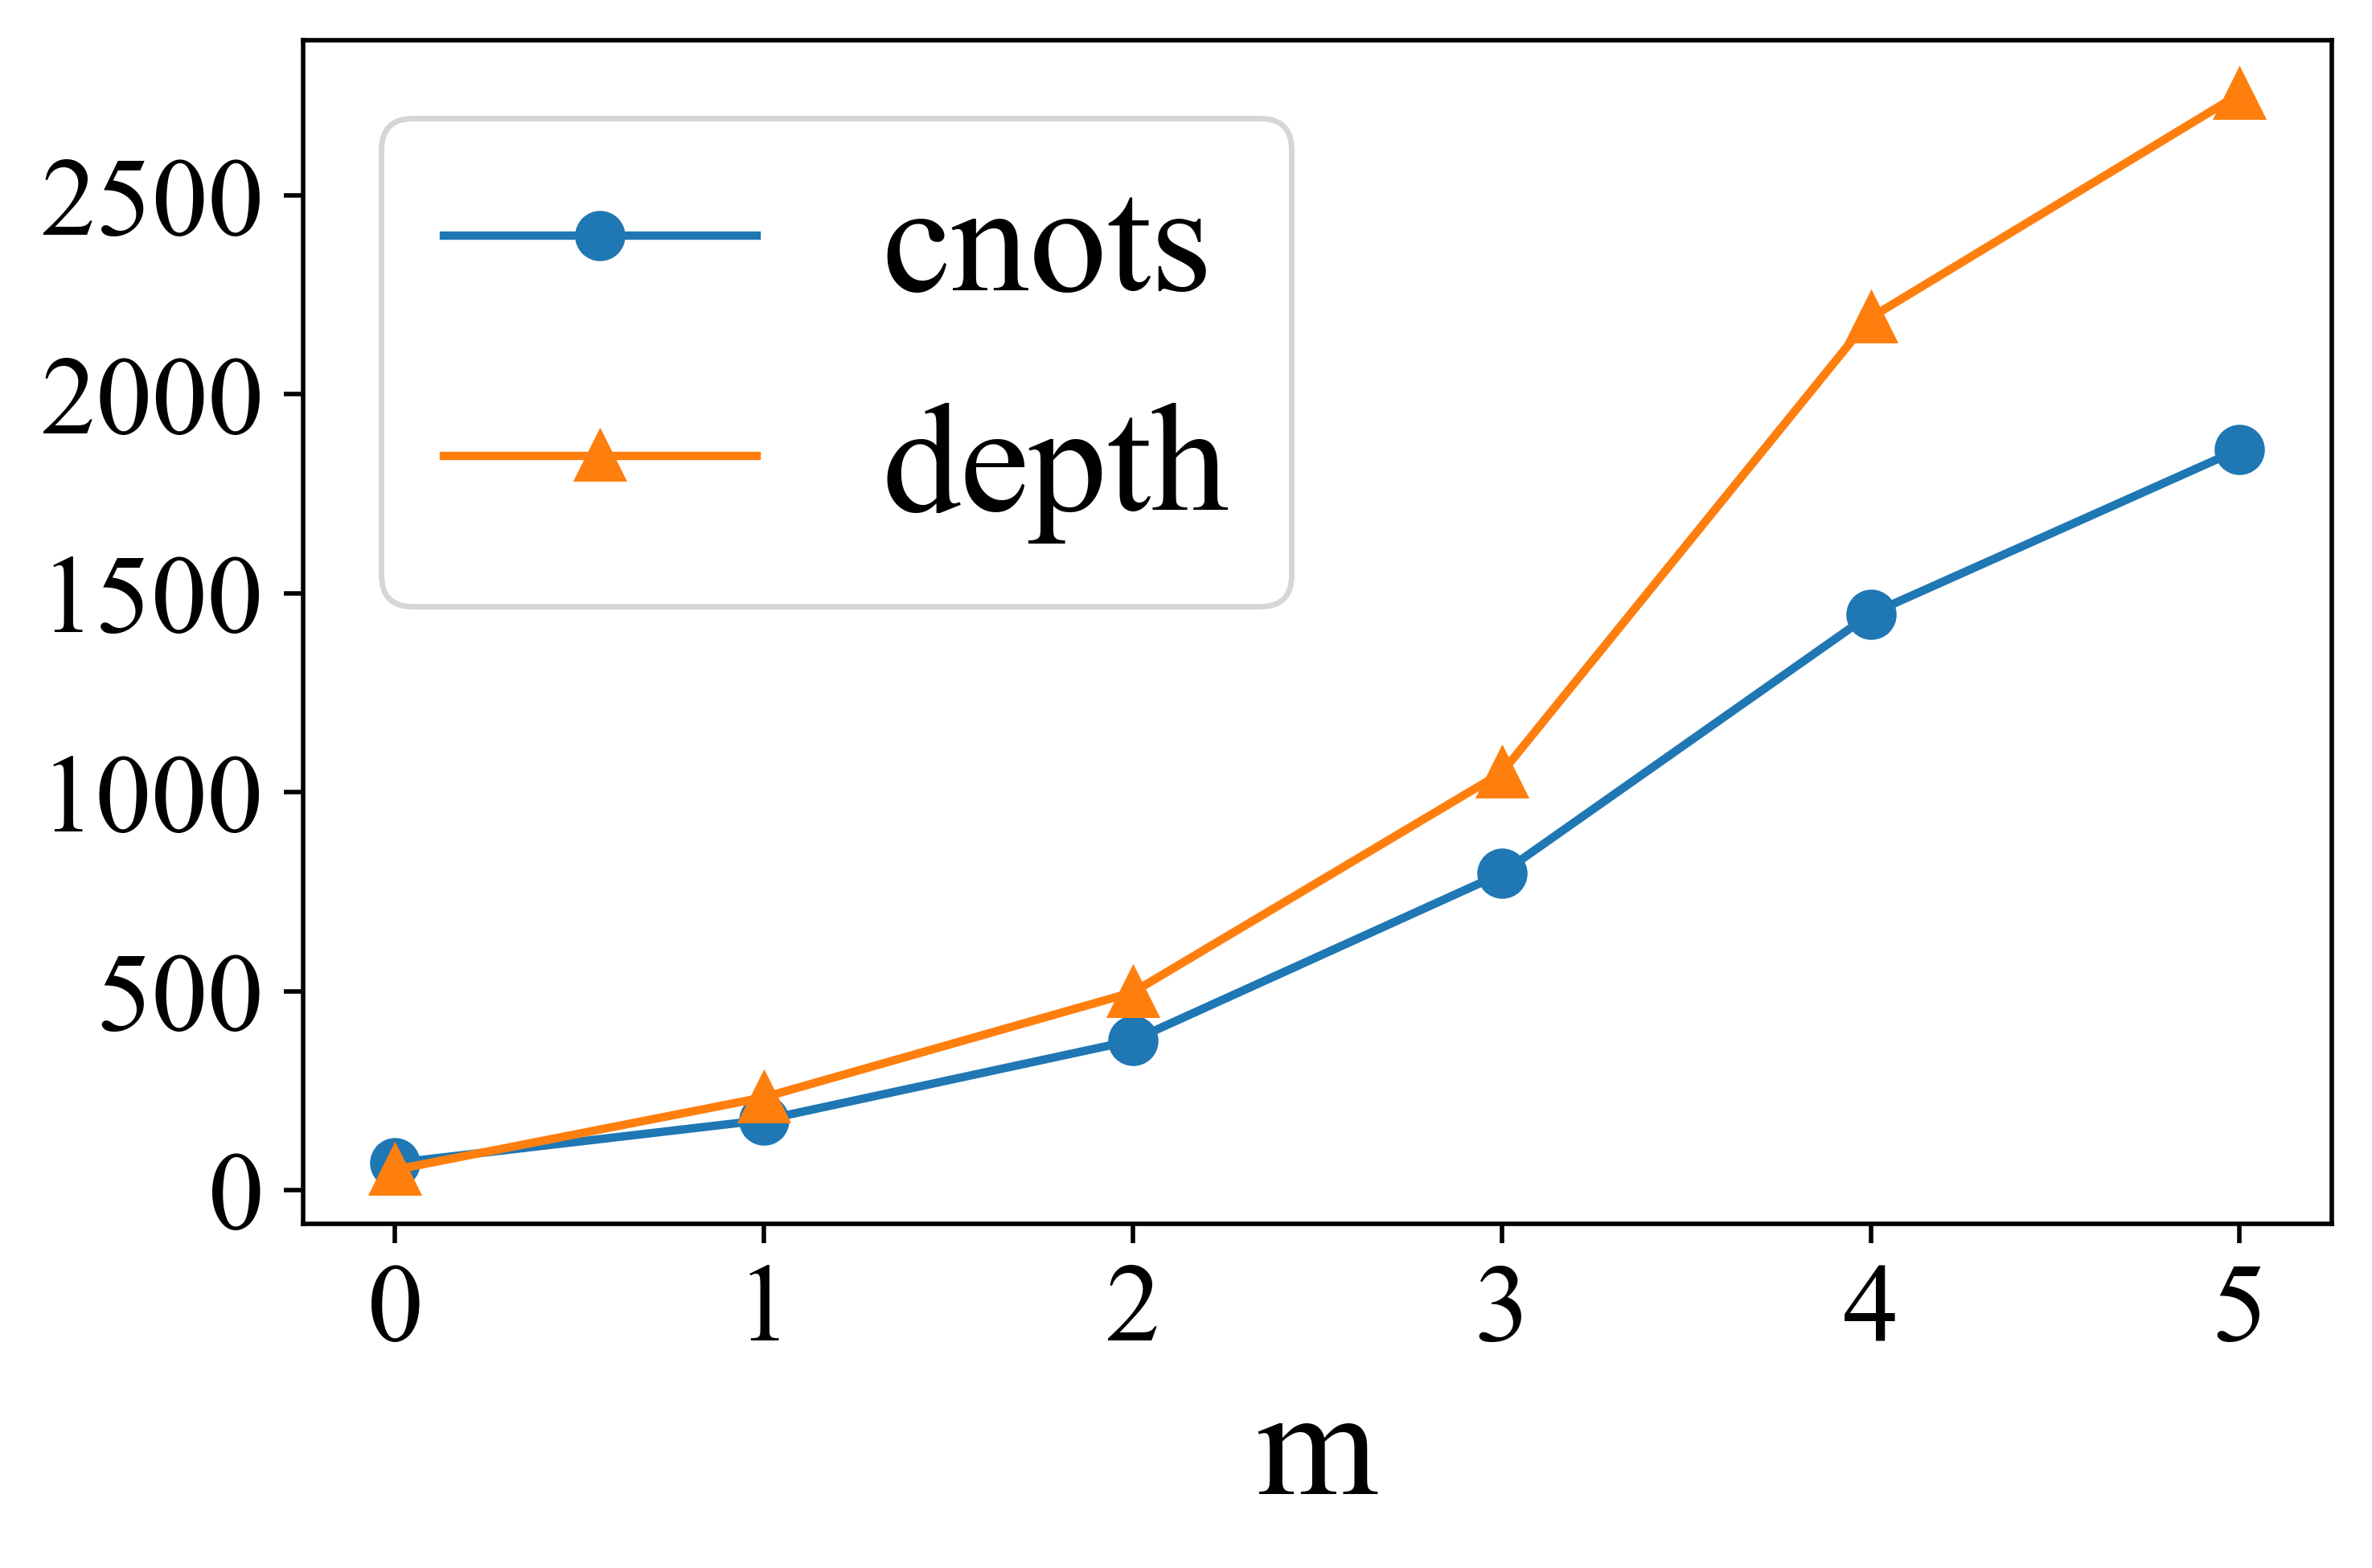

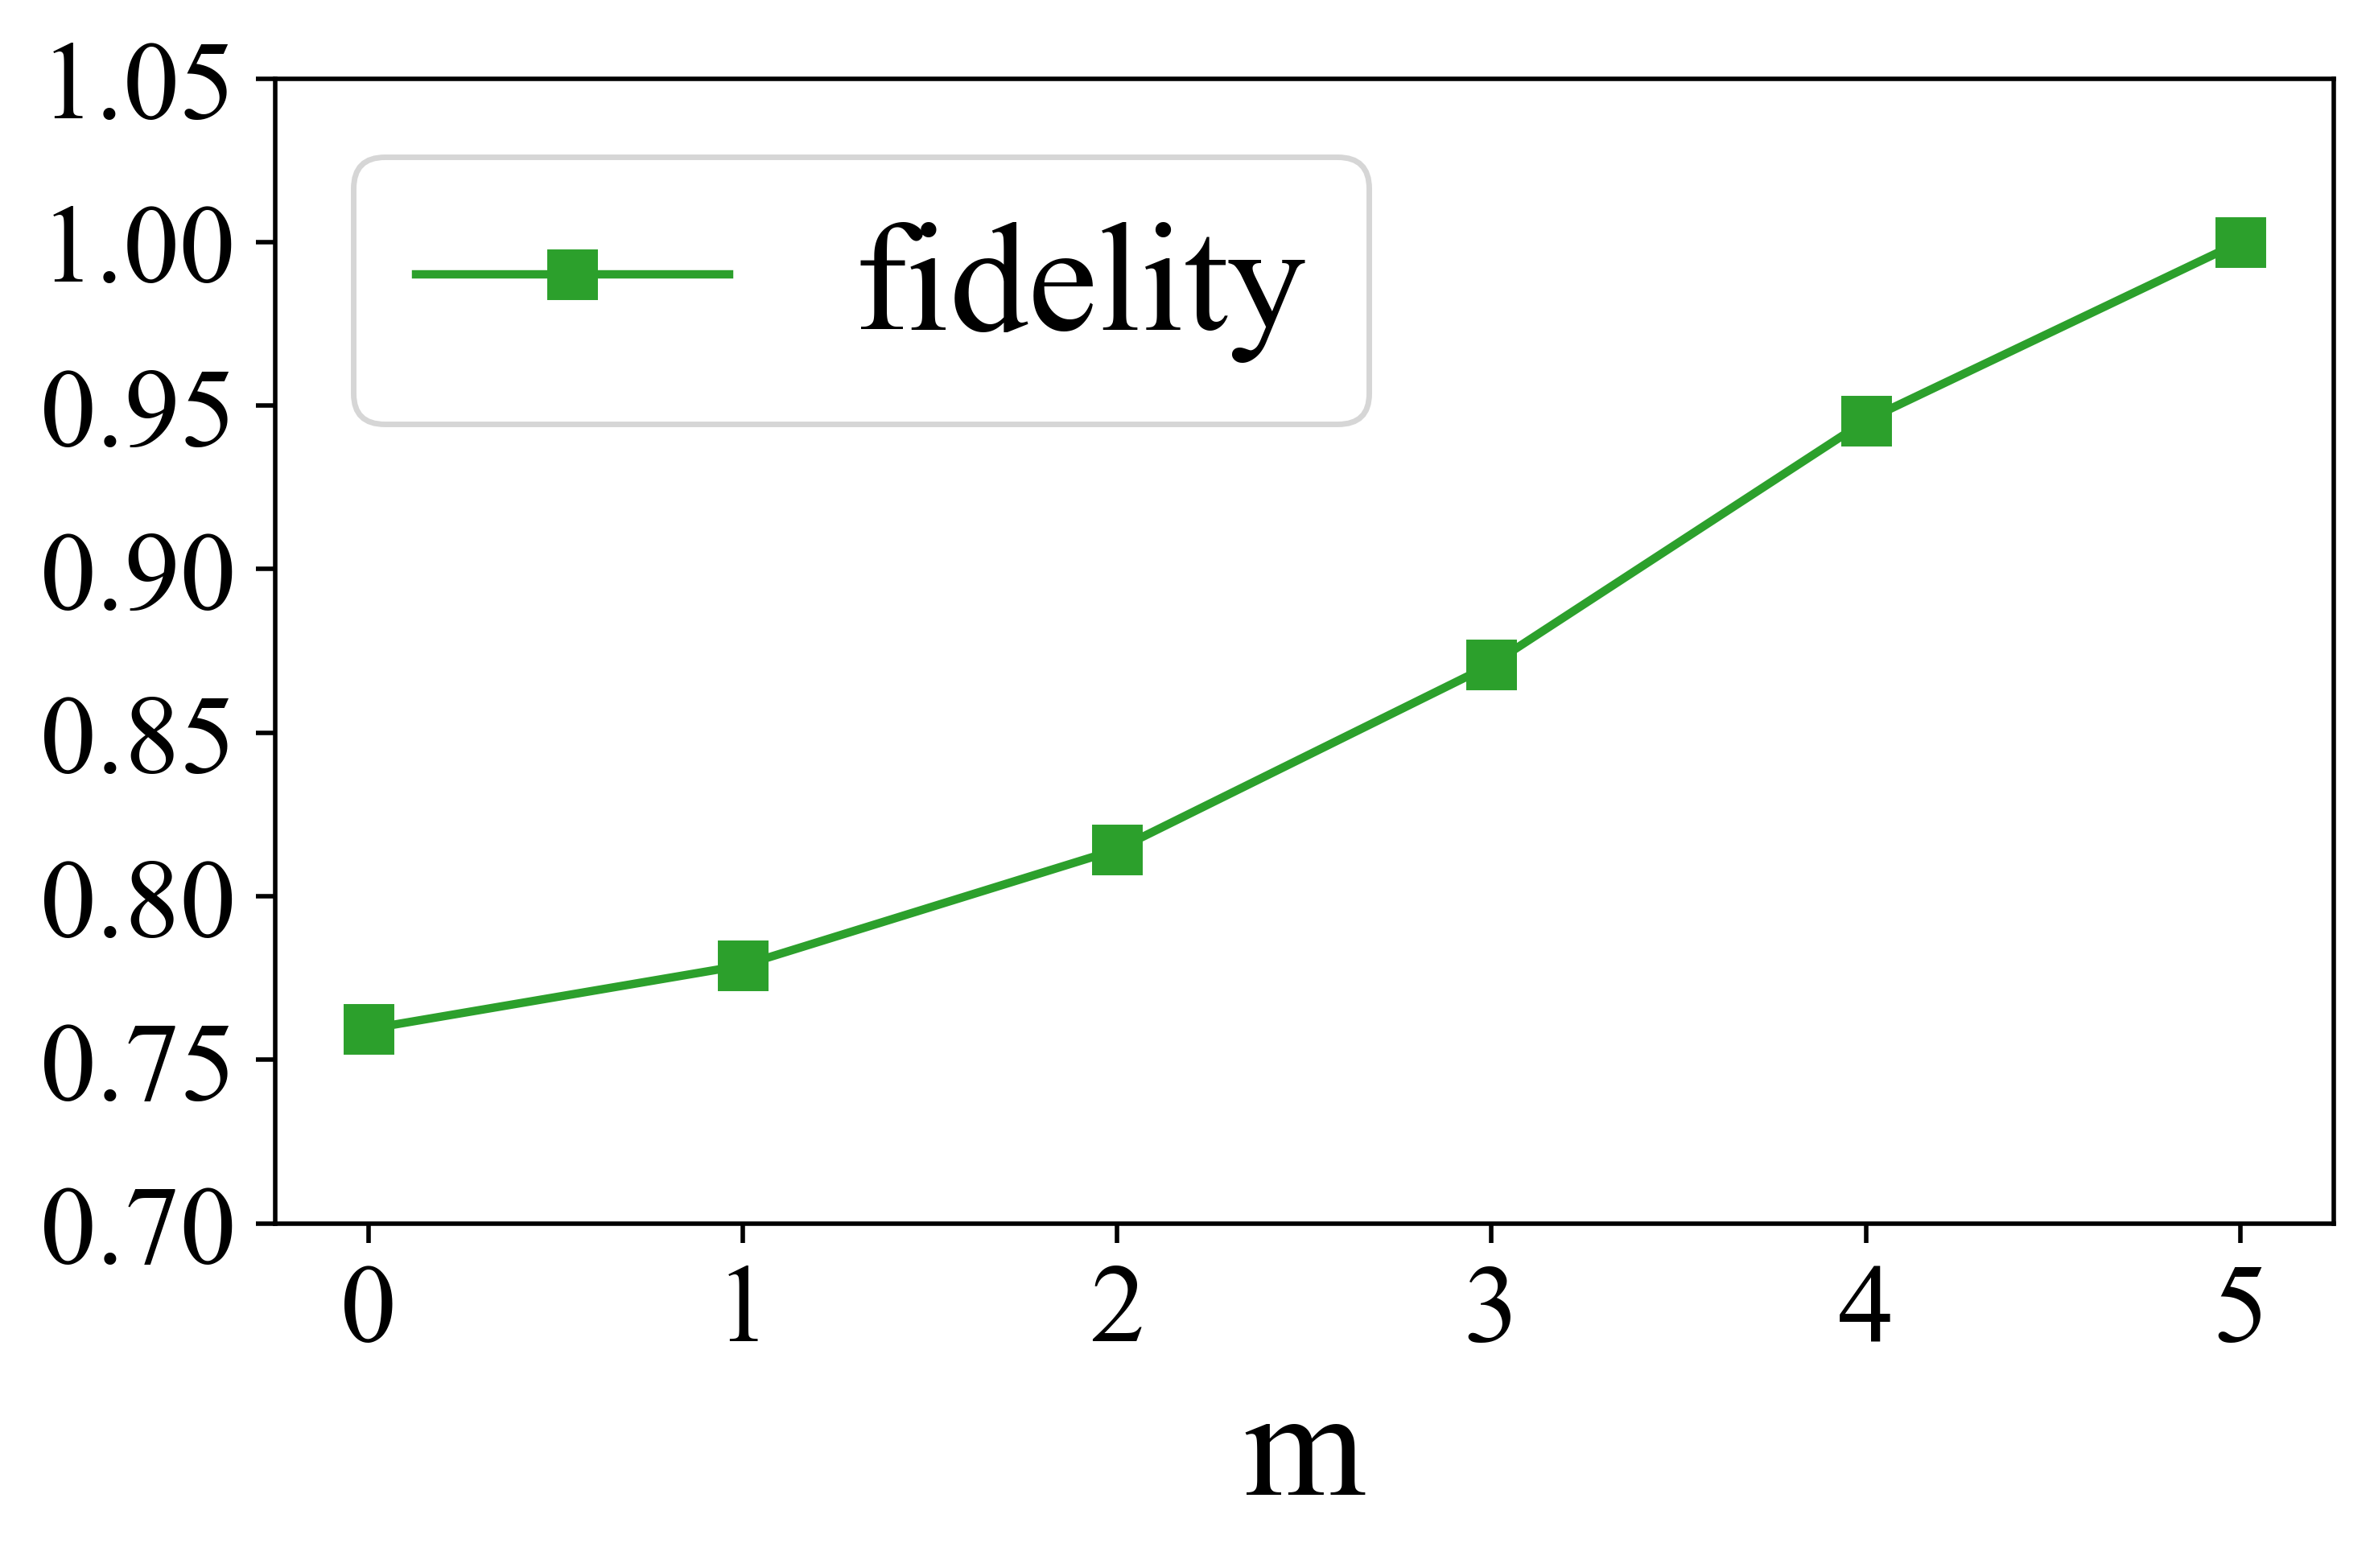

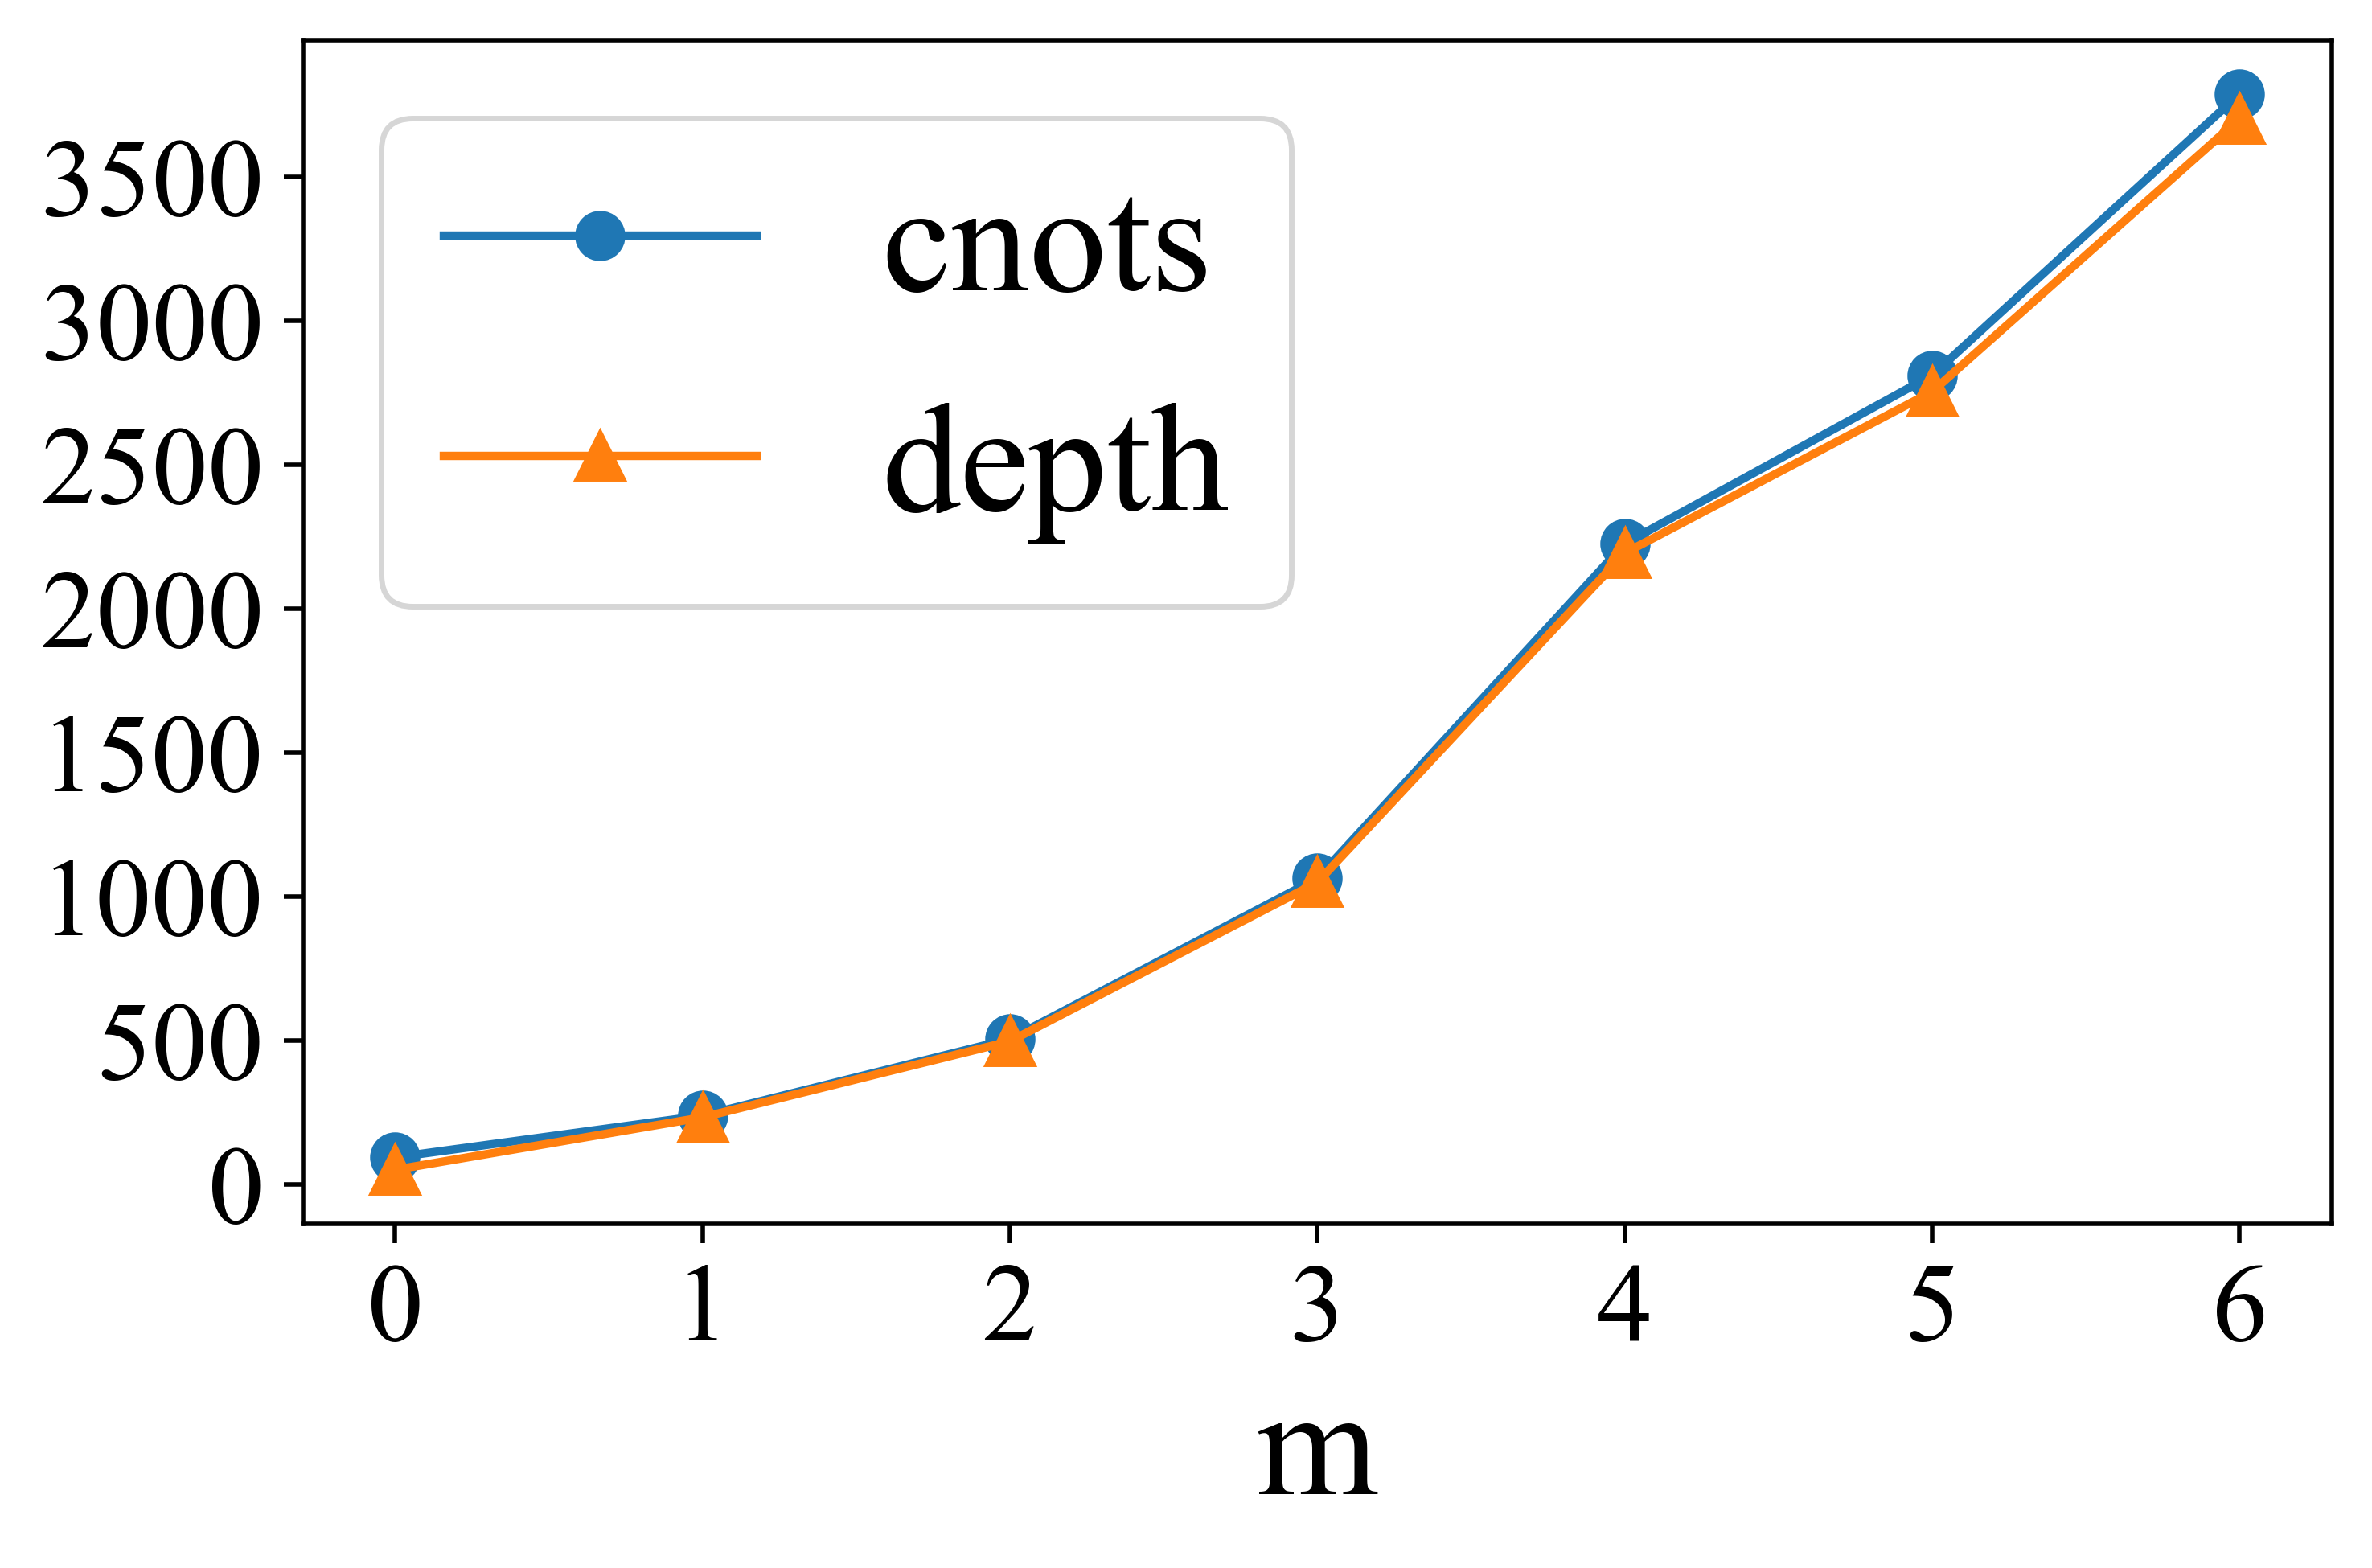

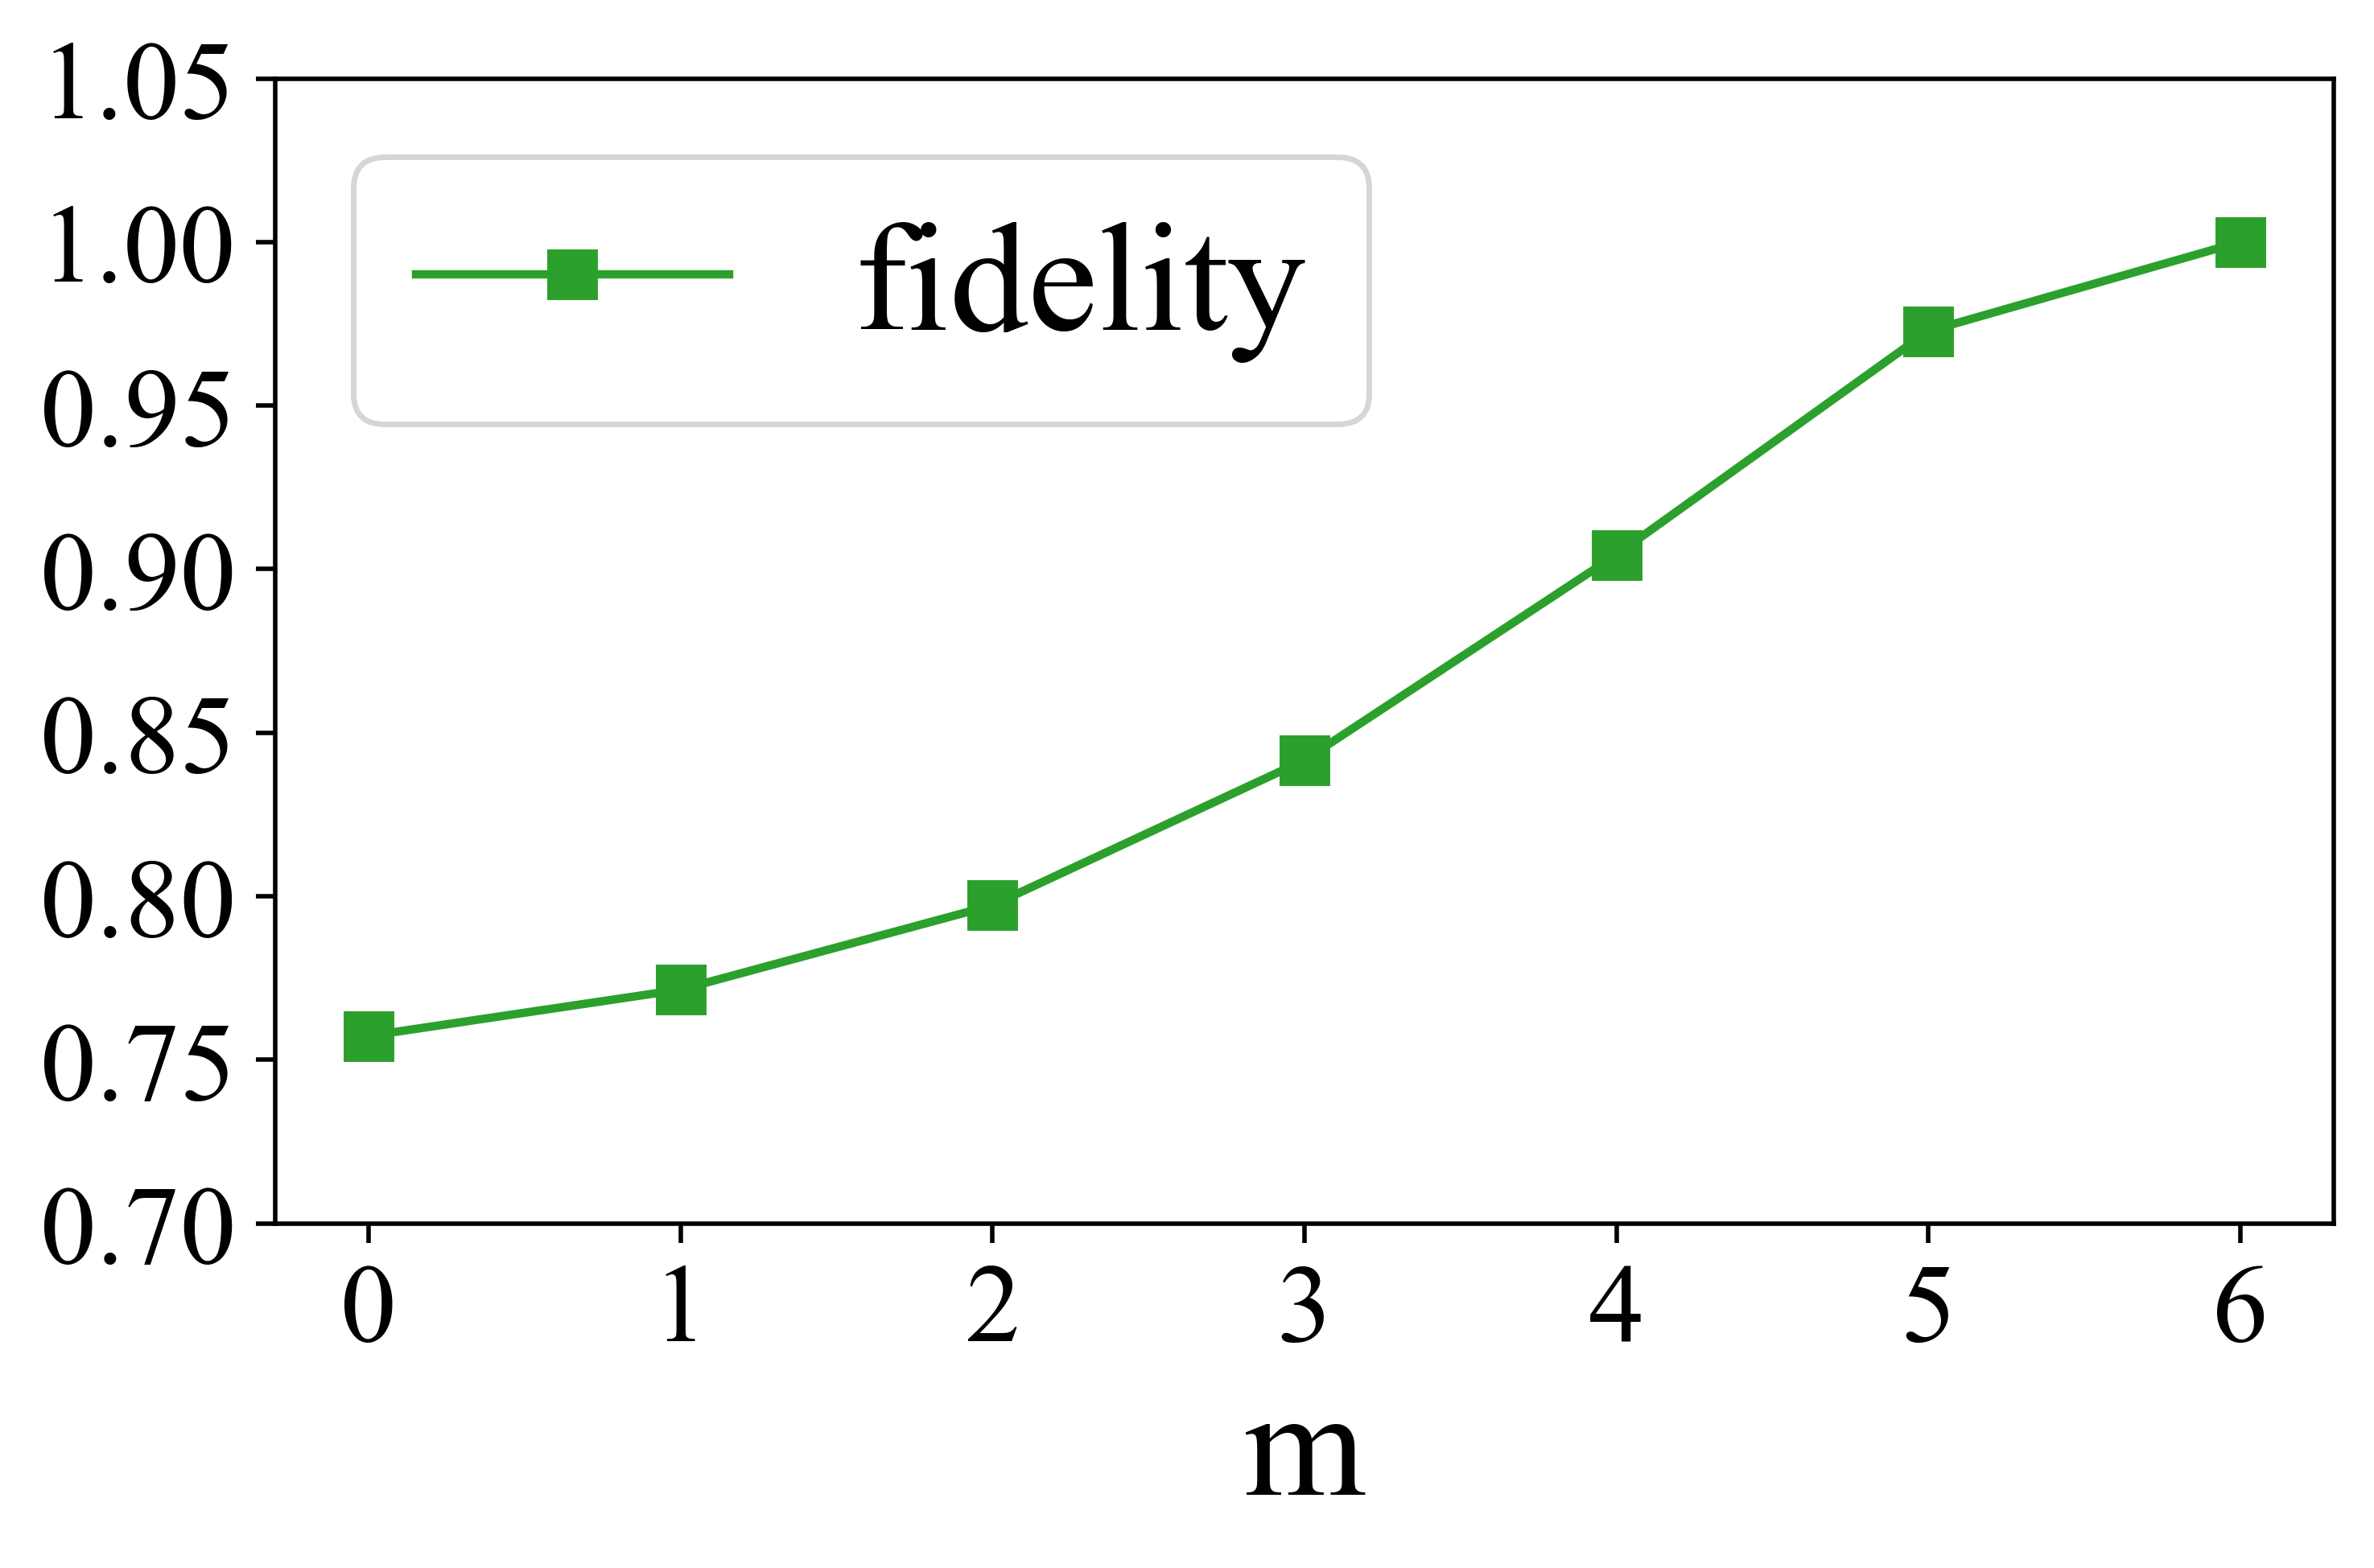

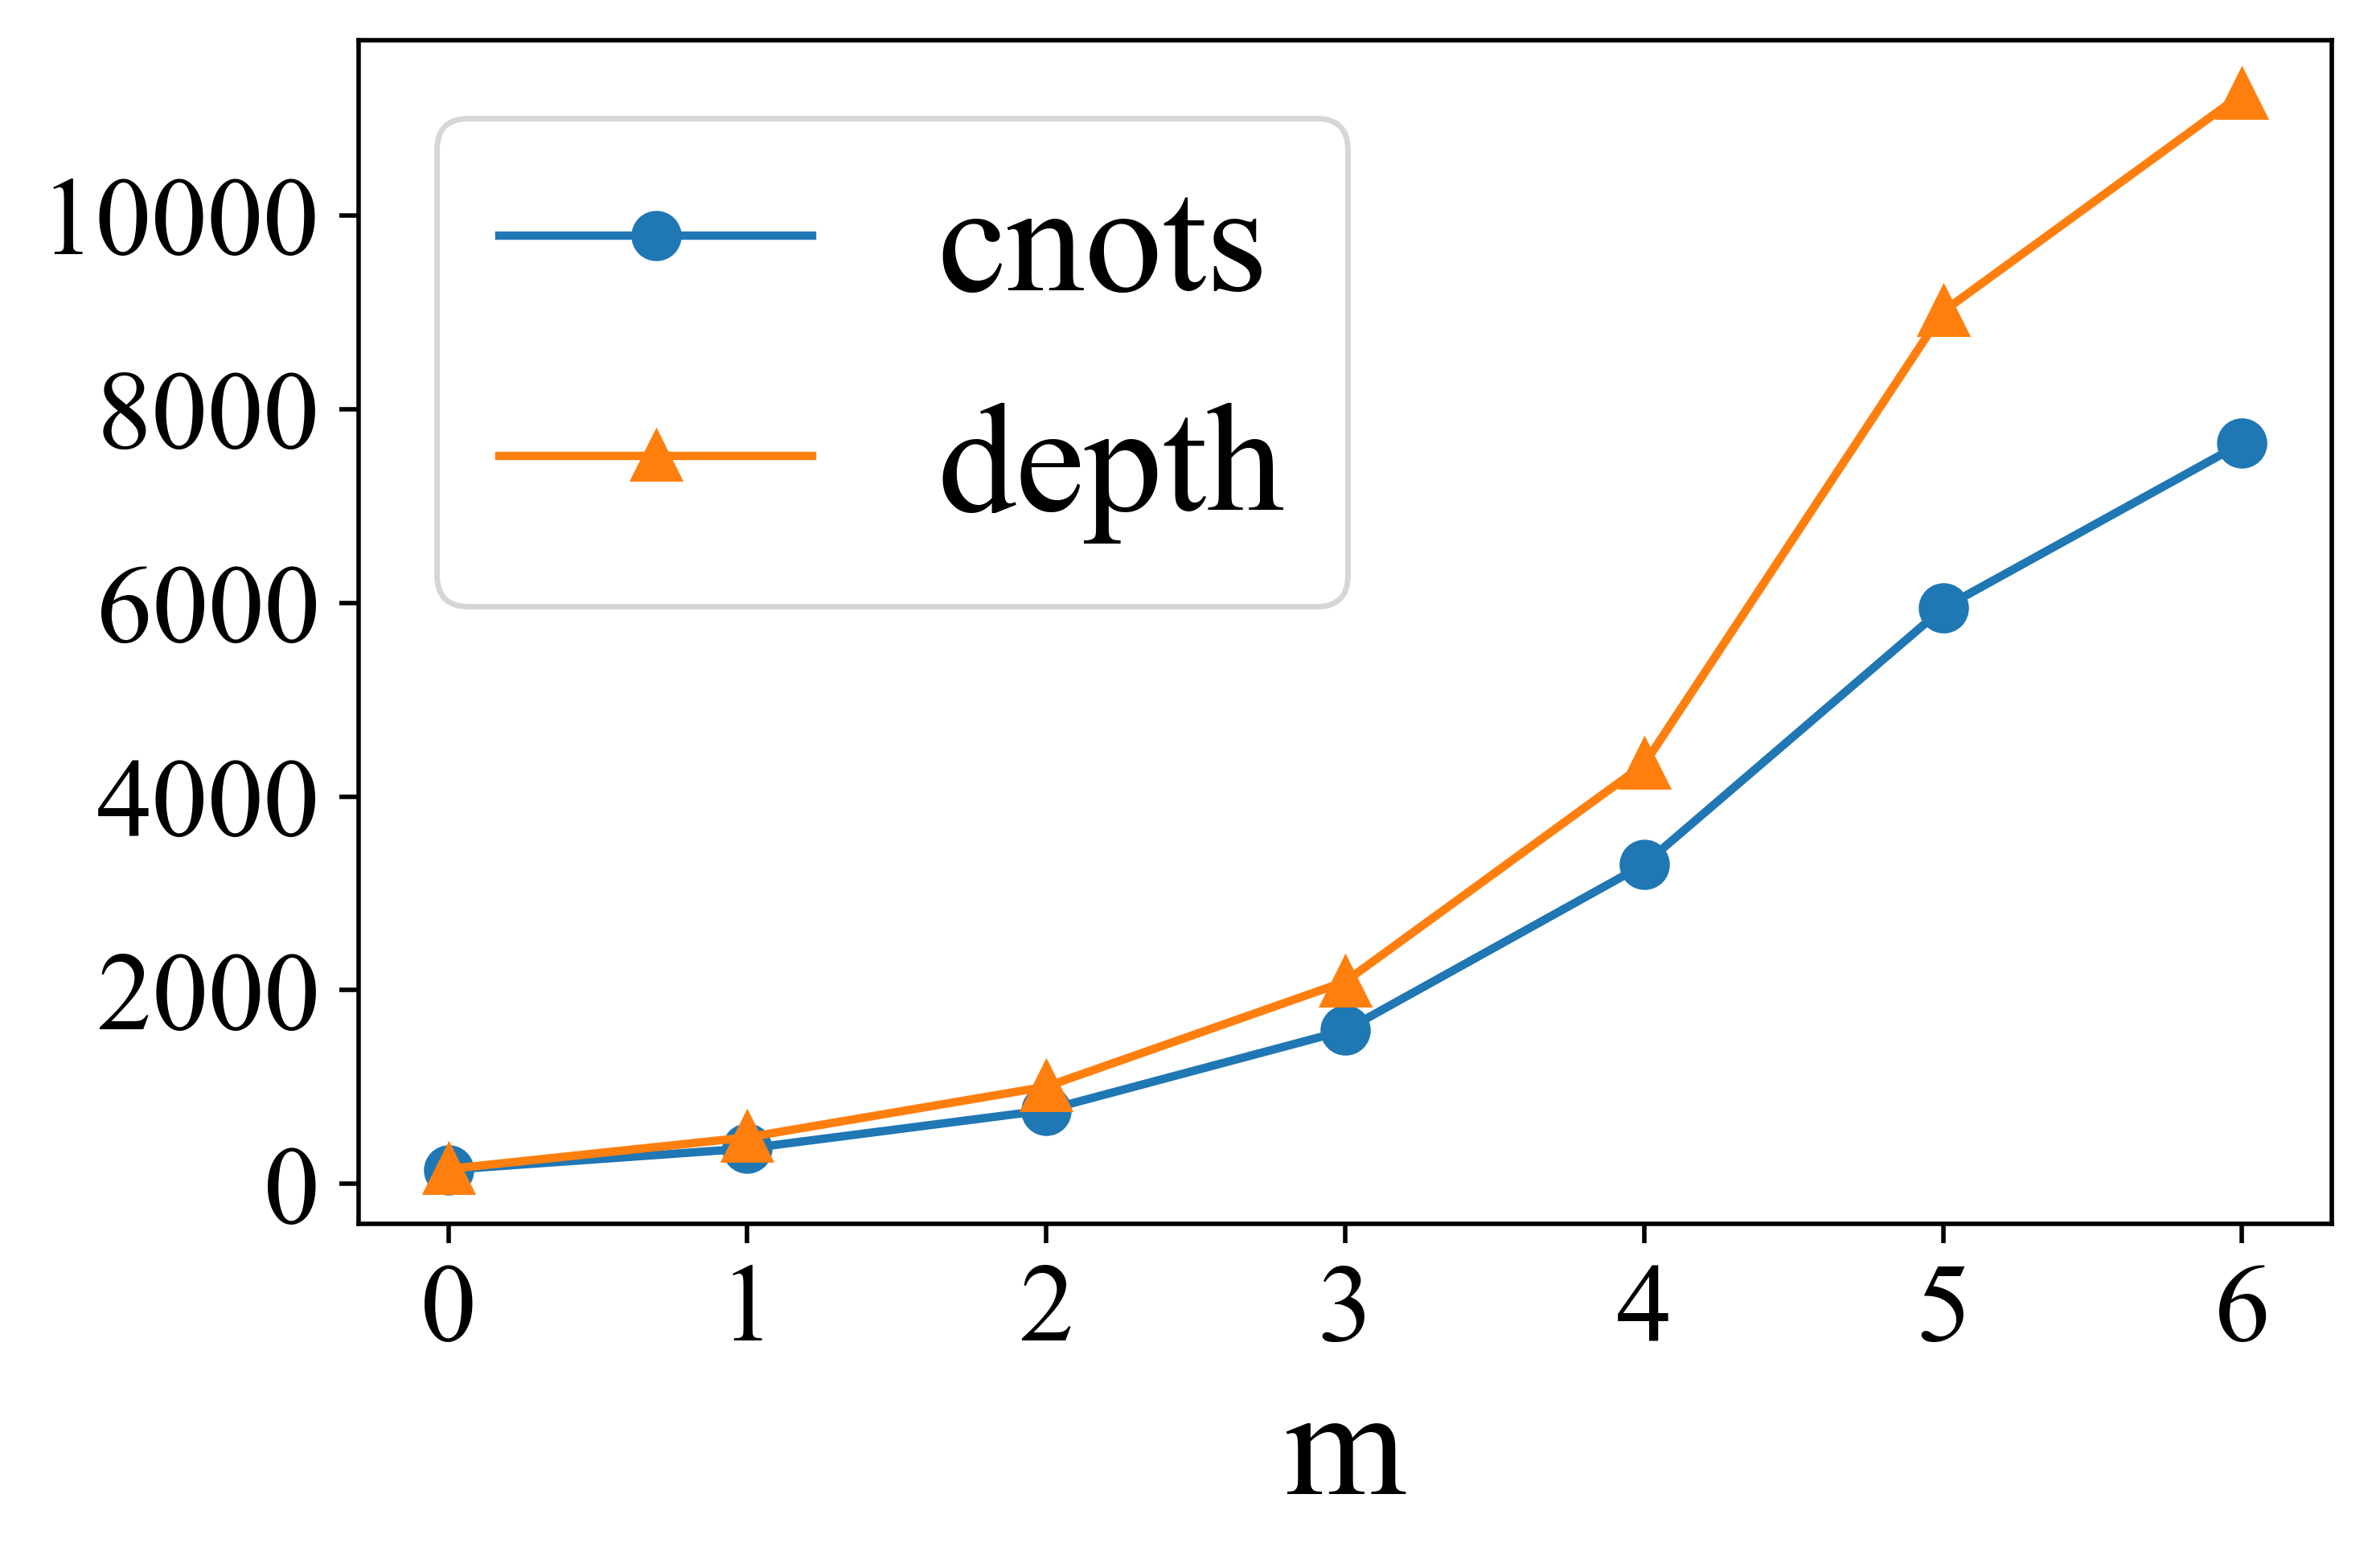

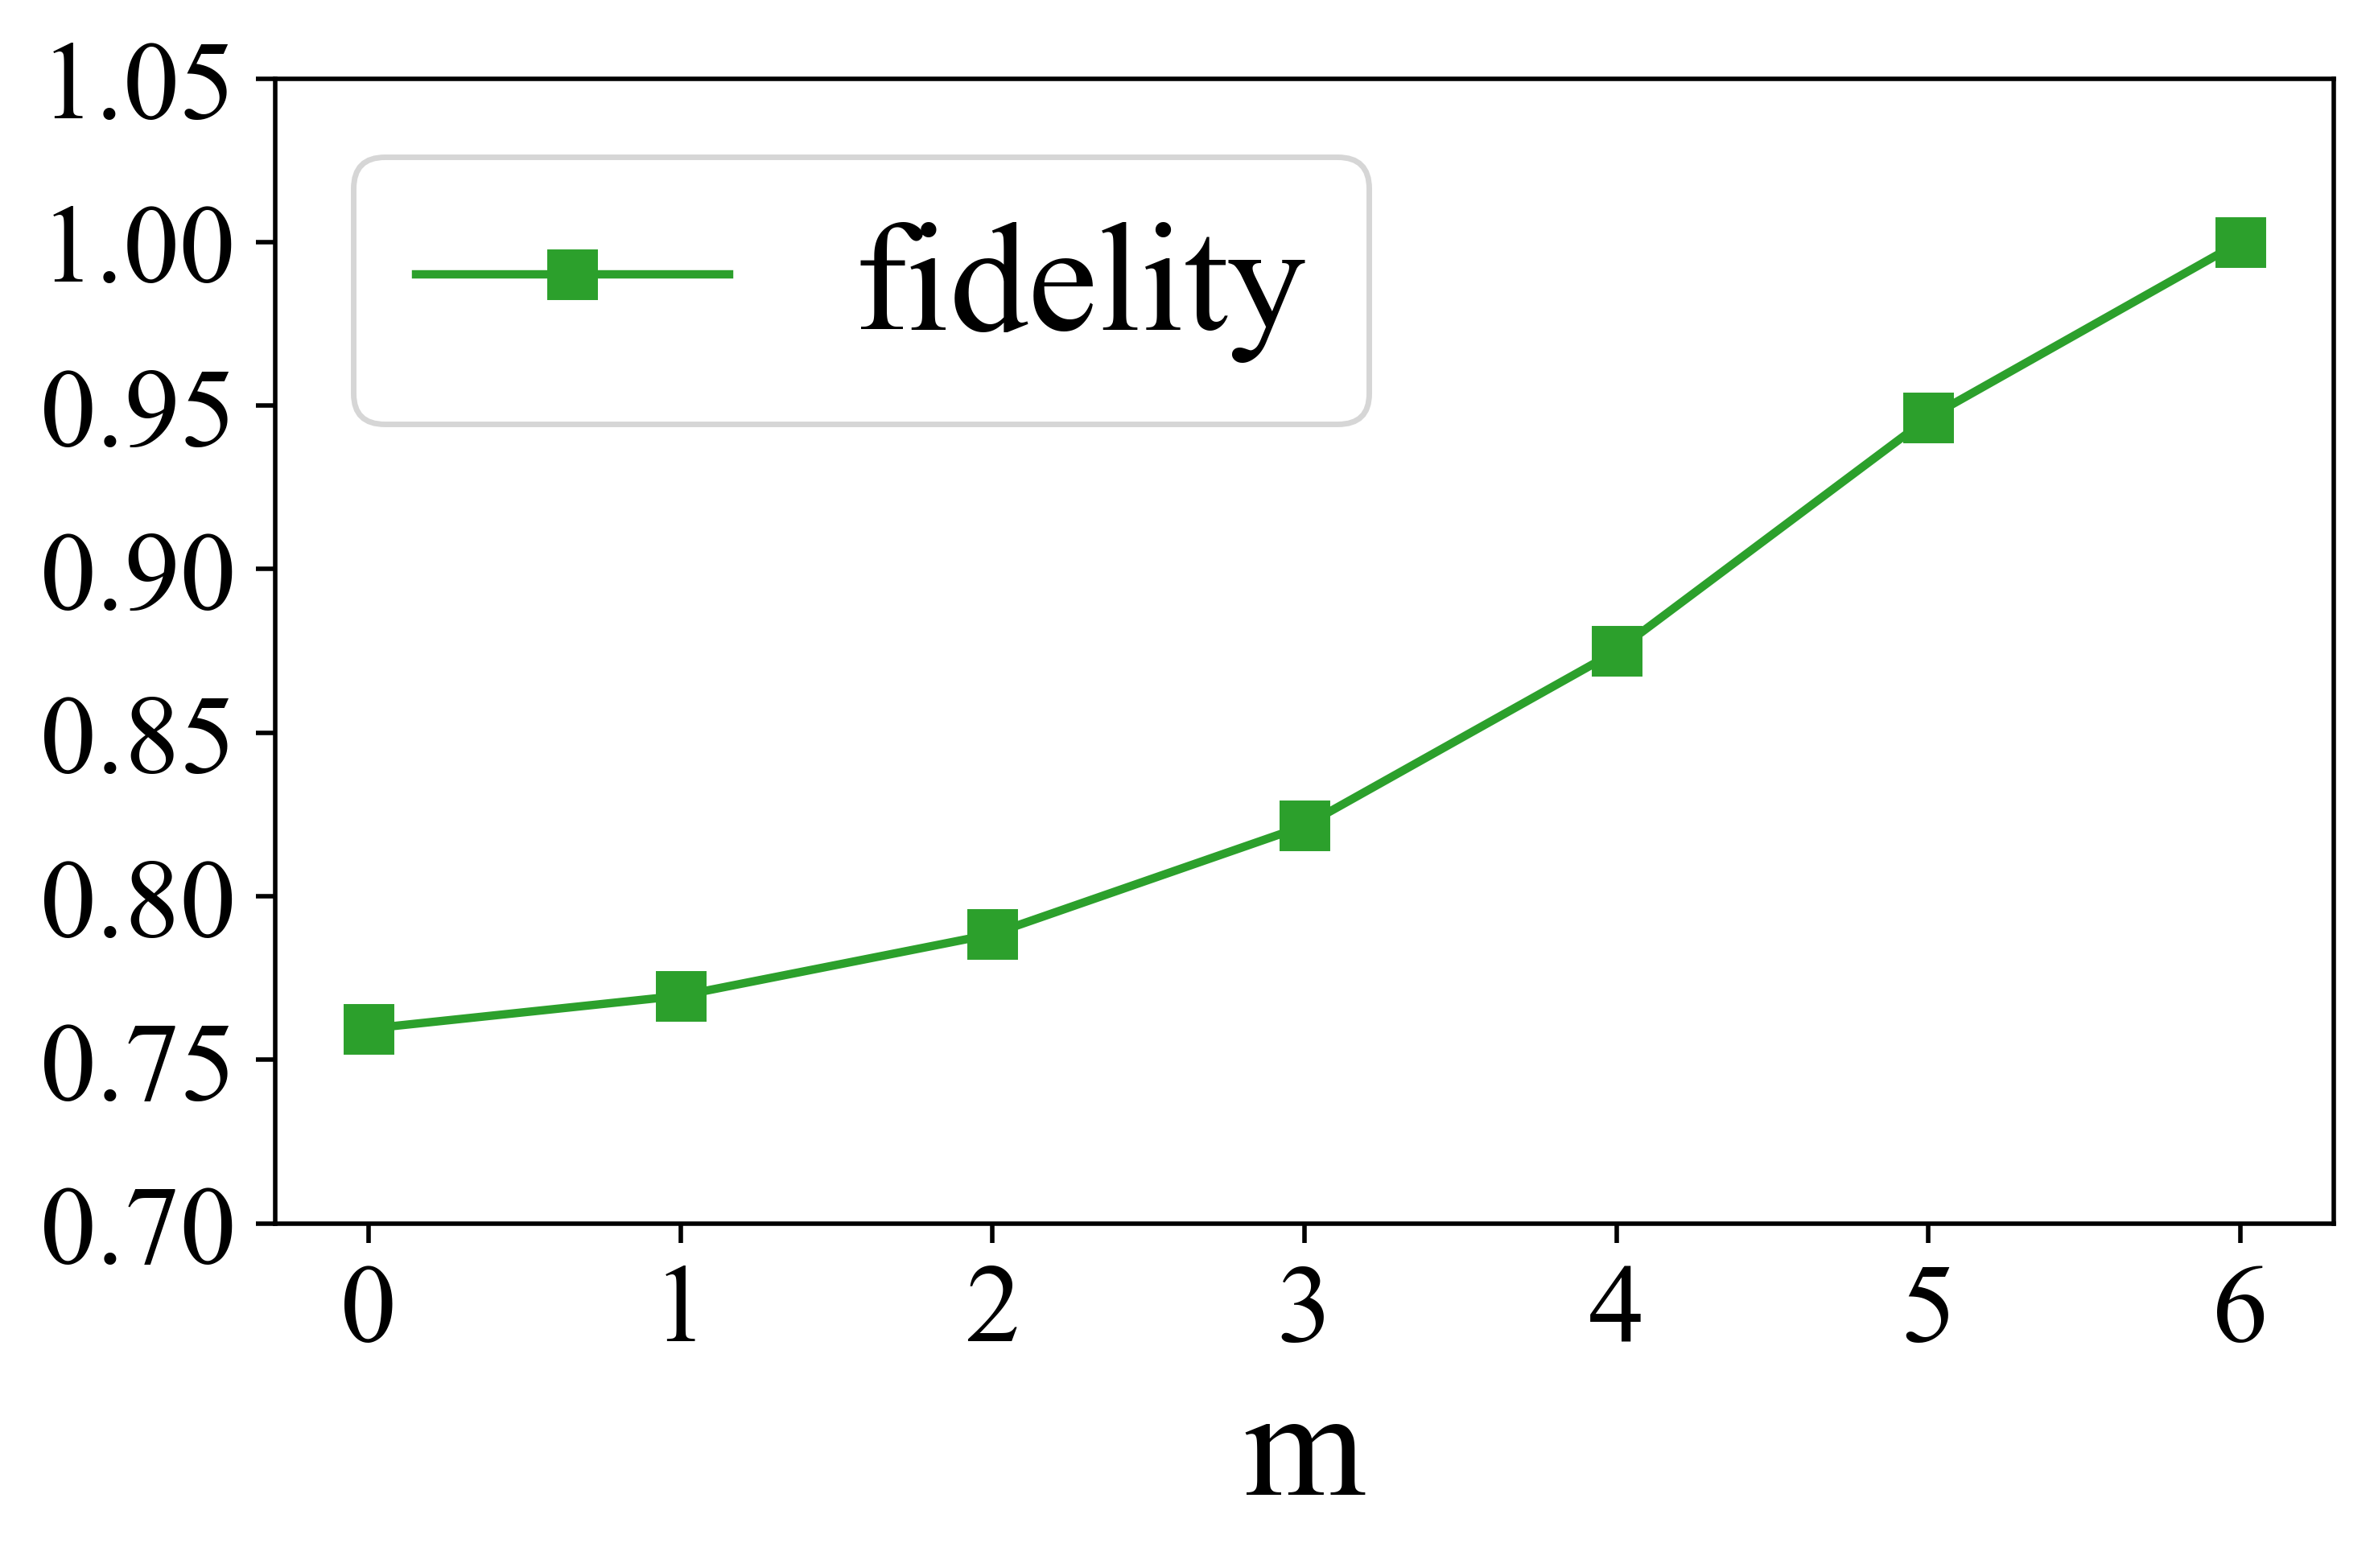

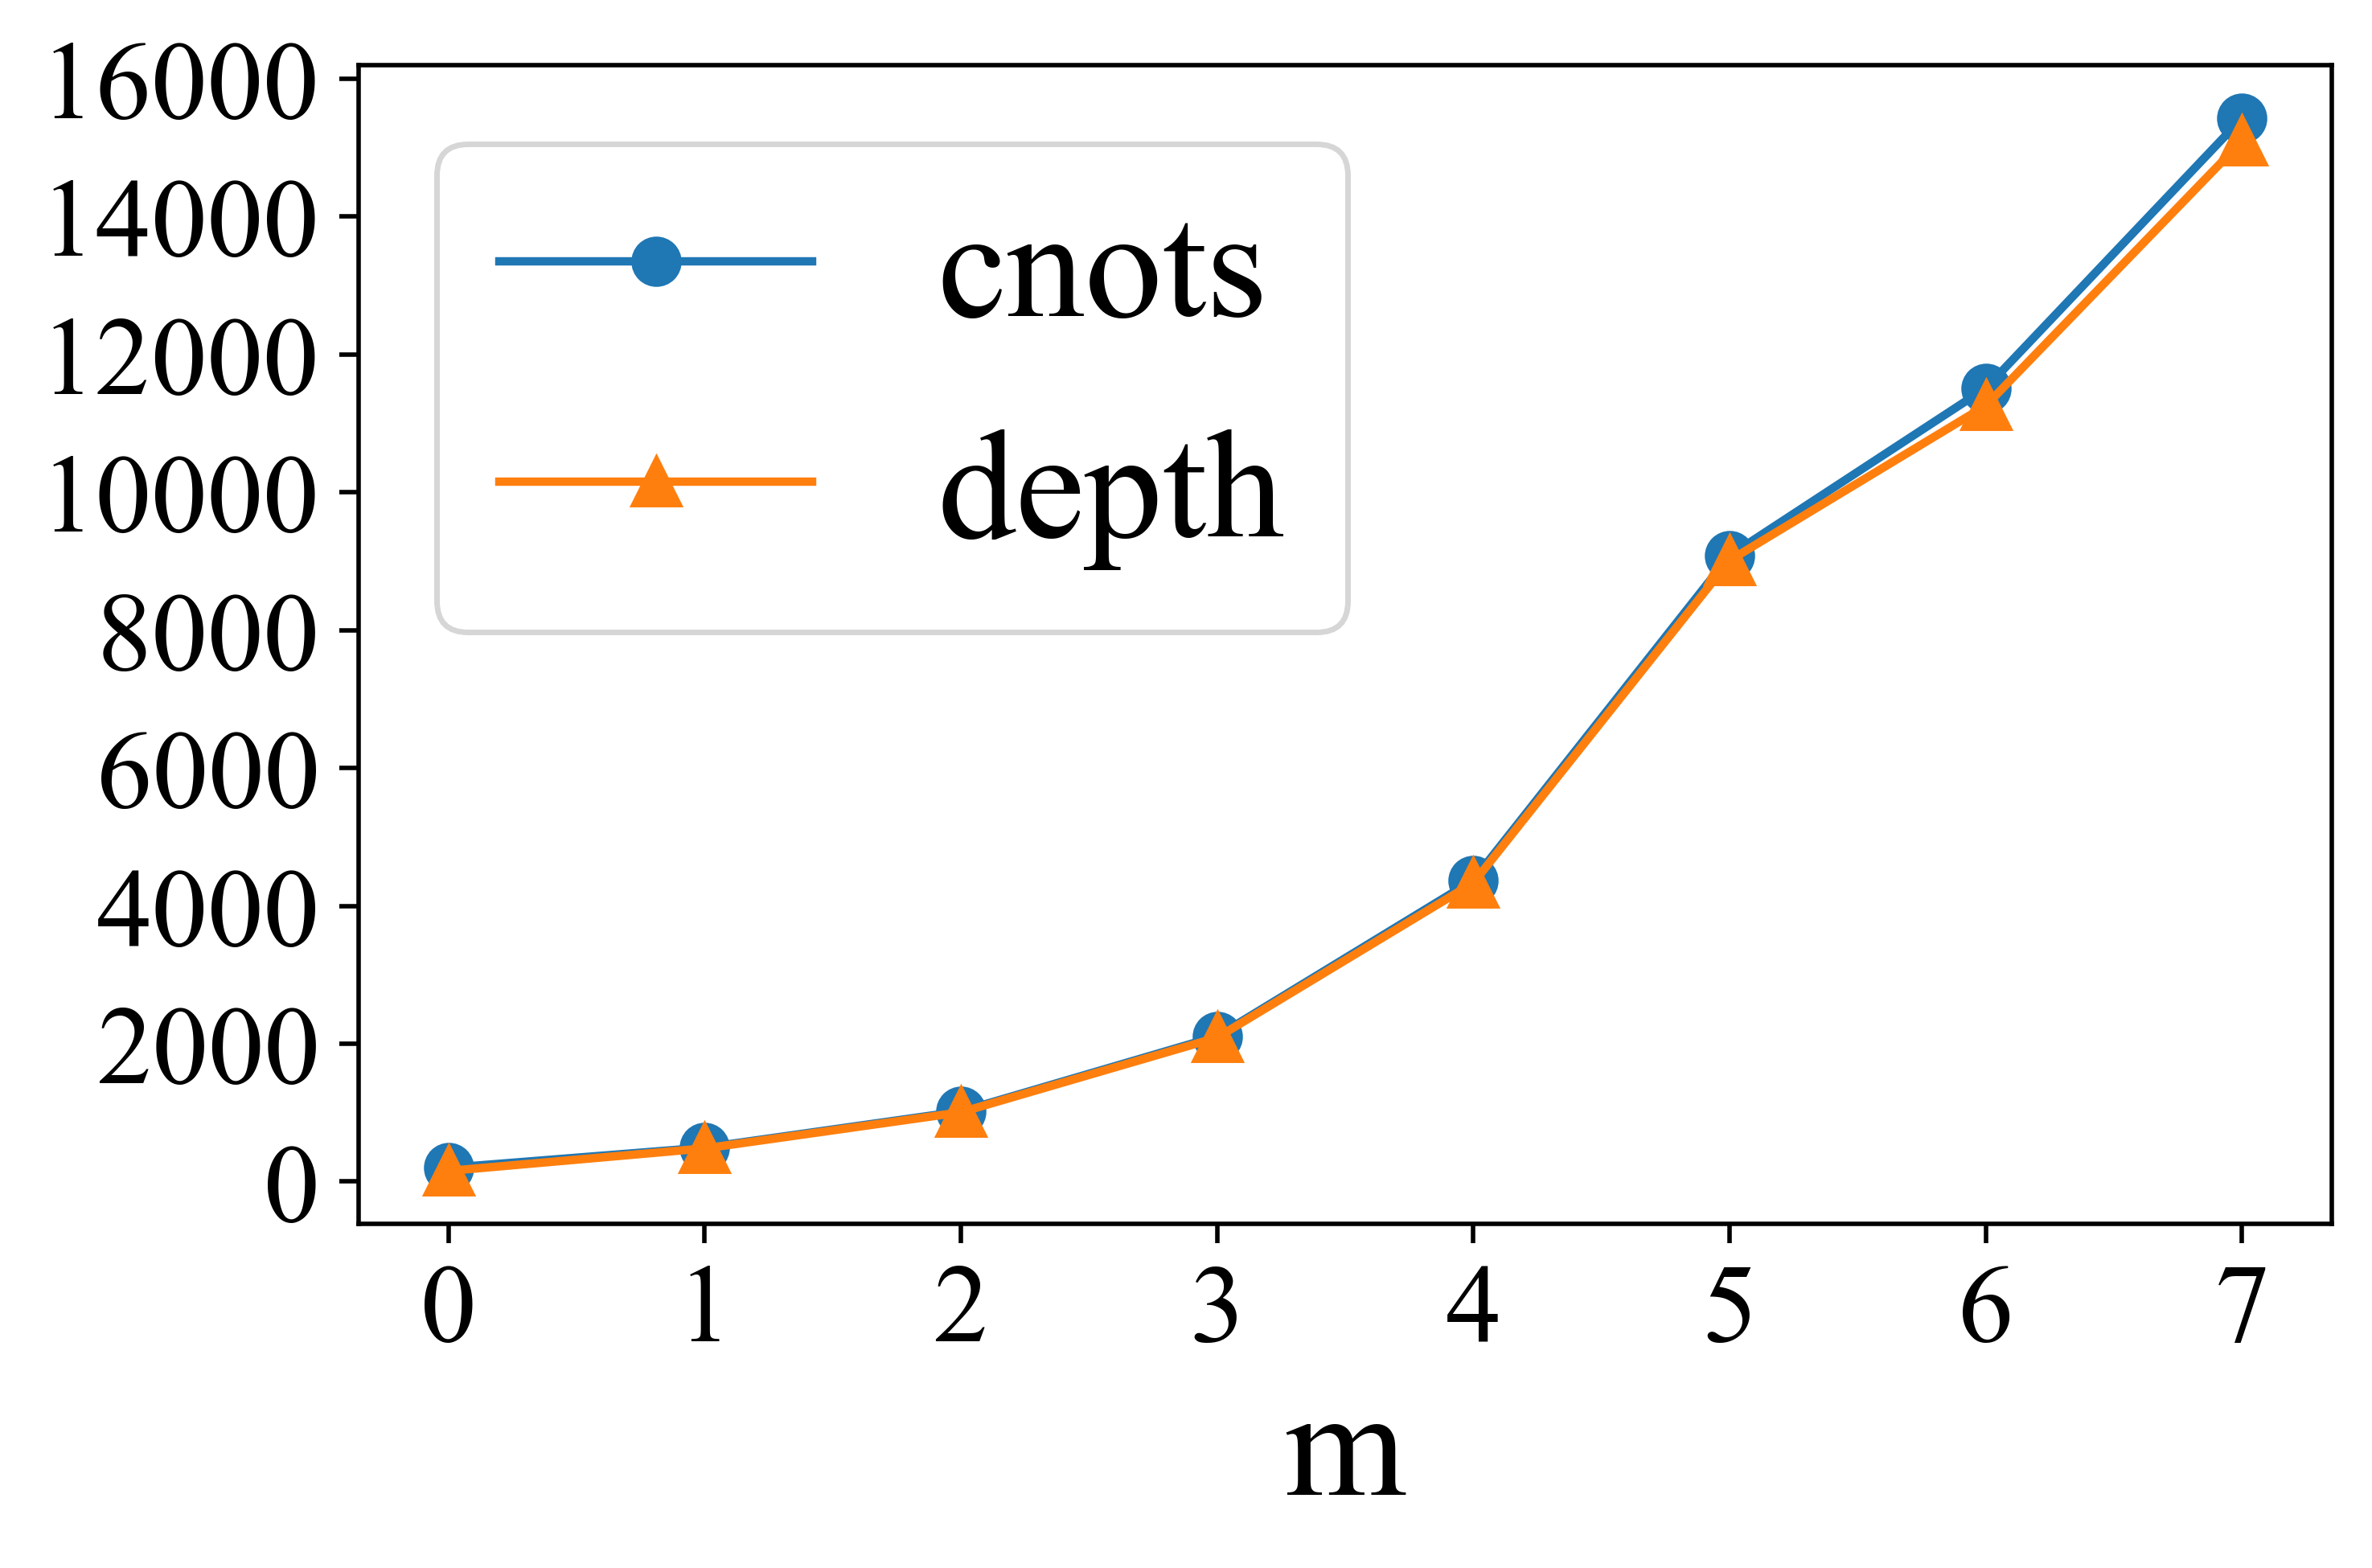

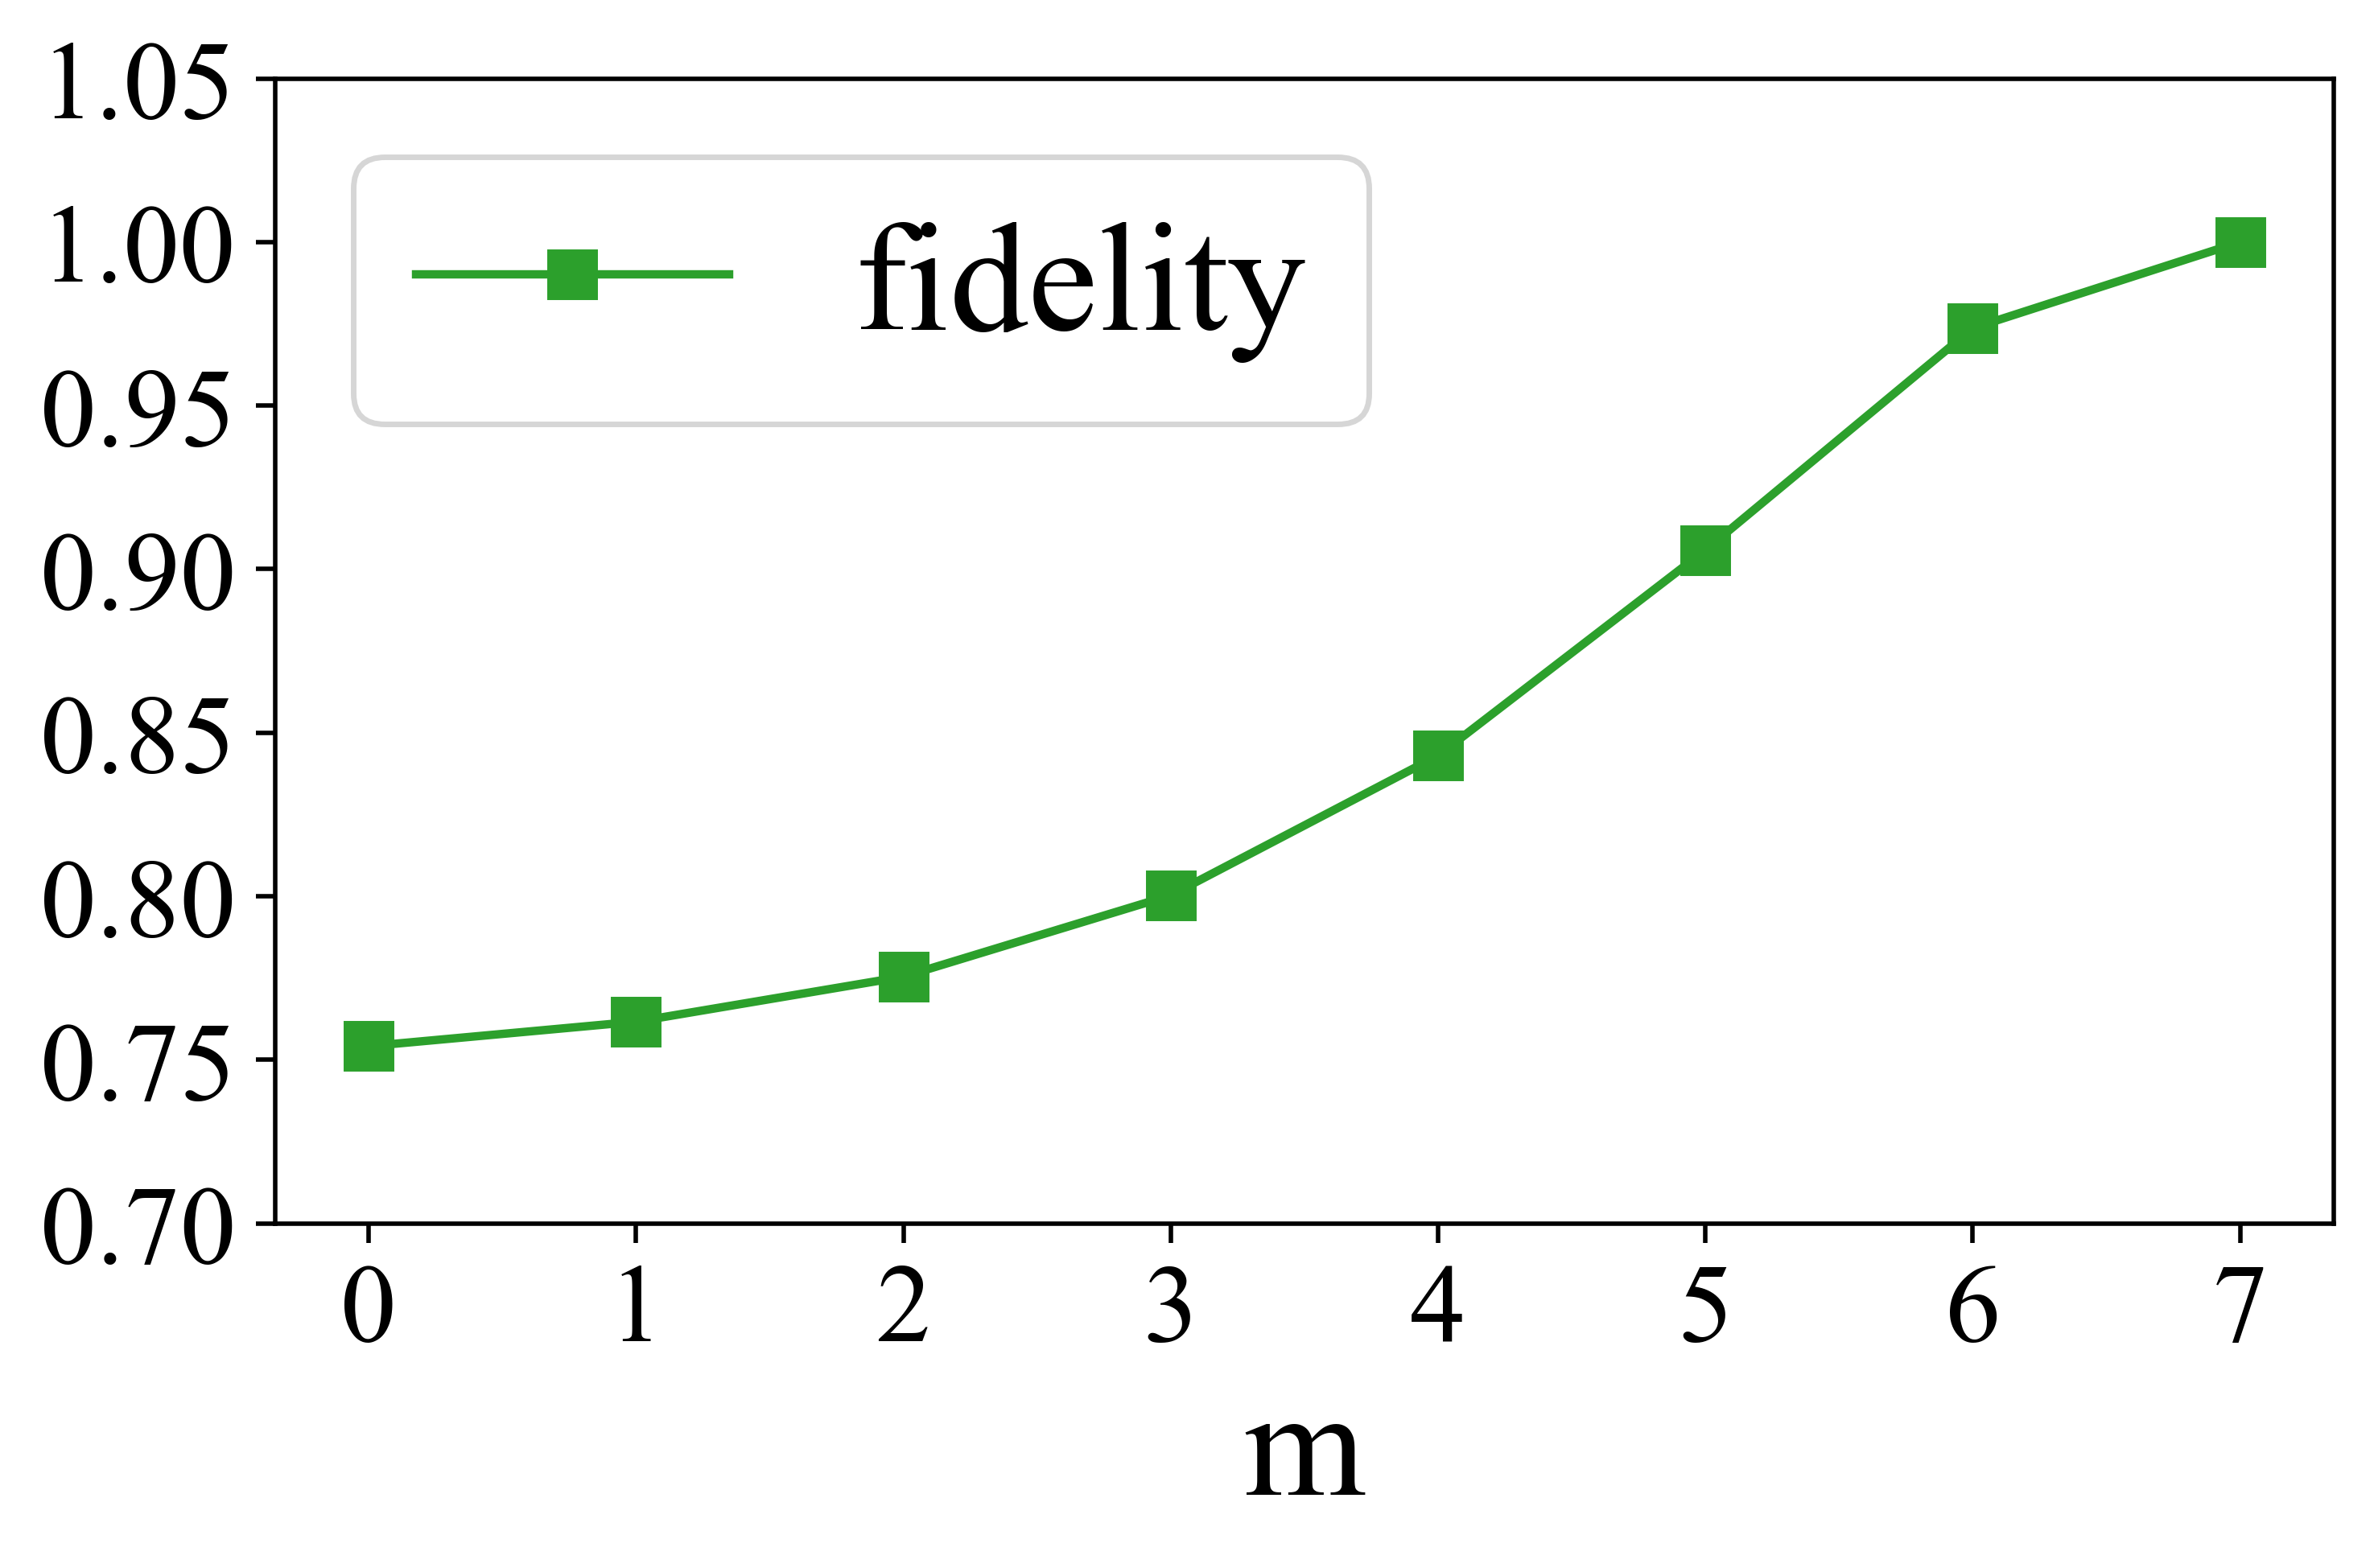

In [13]:
def plot1(n, r, fidelity):
    # libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.ticker import FormatStrFormatter
    
    plt.rcParams["font.family"] = "Times New Roman"

    # Data
    df=pd.DataFrame({ 'x_values': r, 'fidelity': fidelity })

    # multiple line plots
    plt.plot( 'x_values', 'fidelity', 'C2' , data=df, marker='s', markersize=8)
    plt.xticks(r) # force integer on x axis
    # show legend
    plt.legend(loc='upper left')
    
    # config
    plt.legend(loc='upper left', fontsize=28)
    plt.xticks(r, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('m', fontsize=28)
    plt.gcf().set_dpi(500)
    
    # format y axis numbers
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim([0.7, 1.05])

    # show graph
    plt.tight_layout()
    plt.savefig(f'save/fidelity'+str(n)+f'qubits.pdf')
    plt.show()

def plot2(n, r, n_cx, n_dp):
    # libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    plt.rcParams["font.family"] = "Times New Roman"
    
    # Data
    df=pd.DataFrame({ 'x_values': r, 'cnots': n_cx, 'depth': n_dp })

    # multiple line plots
    plt.plot( 'x_values', 'cnots' , data=df, marker='o', markersize=8)
    plt.plot( 'x_values', 'depth' , data=df, marker='^', markersize=8)
    plt.xticks(r) # force integer on x axis
    # show legend
    plt.legend()
    
    # config
    plt.legend(fontsize=28)
    plt.xticks(r, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('m', fontsize=28)
    plt.gcf().set_dpi(500)
    
    # show graph
    plt.tight_layout()
    plt.savefig(f'save/hyperparameter'+str(n)+f'qubits.pdf')
    plt.show()

def plot_result(n, result):
    r_range = [r[0] for r in result[n]]
    n_cx    = [r[1] for r in result[n]]
    n_dp    = [r[2] for r in result[n]]

    plot2(n, r_range, n_cx, n_dp)

def plot_fidelity(n, result):
    r_range = [r[0] for r in result[n]]
    fidelity = [r[3] for r in result[n]]

    plot1(n, r_range, fidelity)

for n in range(min_n, max_n+1):
    plot_result(n, result)
    plot_fidelity(n, result)
